In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
Ensemble learning: Combine the predictions of multiple models (e.g., VGG, ResNet, and Xception) to create an ensemble model. Ensemble learning can often lead to better performance by leveraging the strengths of each individual model.
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ttttraaa/Train_data1/Train/fungus/_9_858.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_73_9942.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_9_2380.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_14_5734.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_39_2246.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_101_7125.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_85_8166.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_16_8271.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_86_5036.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_9_8445.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_26_6877.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_40_5864.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_110_1749.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_101_1327.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_37_8624.png
/kaggle/input/ttttraaa/Train_data1/Train/fungus/_44_3483.png
/kaggle/input/ttttraaa/Tr

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.efficientnet import EfficientNetB0

# Load VGG16
vgg16_model = VGG16(weights='imagenet')

# Load VGG19
vgg19_model = VGG19(weights='imagenet')

# Load ResNet50
resnet50_model = ResNet50(weights='imagenet')

# Load InceptionV3
inceptionv3_model = InceptionV3(weights='imagenet')

# Load DenseNet121
densenet121_model = DenseNet121(weights='imagenet')


33188688/33188688 [==============================] - 0s 0us/step


In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, VGG19, ResNet50, InceptionV3, DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from tqdm import tqdm

# Set the paths to your training and validation data
train_data_dir = '/kaggle/input/dataset-1/train_images_aug/aug_images'
validation_data_dir = '/kaggle/input/dataset-1/val_aug/val_aug'

# Set the image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Prepare the data using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Define a function to create a model with a custom output layer
def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Define a function to train a model and return its accuracy
def train_and_evaluate_model(model, train_generator, validation_generator, epochs=10):
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_generator, epochs=epochs, validation_data=validation_generator)
    _, accuracy = model.evaluate(validation_generator)
    return accuracy

# Load the pre-trained models and train them one by one
pretrained_models = [VGG16, VGG19, ResNet50, InceptionV3, DenseNet121]
model_names = ['VGG16', 'VGG19', 'ResNet50', 'InceptionV3', 'DenseNet121']
num_classes = 4

# Create a directory to save the models
save_dir = '/kaggle/working/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

accuracies = []

for model_name, pretrained_model in zip(model_names, pretrained_models):
    print(f'Training {model_name}...')
    base_model = pretrained_model(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    model = create_model(base_model, num_classes)
    accuracy = train_and_evaluate_model(model, train_generator, validation_generator)
    accuracies.append(accuracy)
    print(f'{model_name} accuracy: {accuracy}')
    
    # Save the trained model in the specified directory
    model_path = os.path.join(save_dir, f'{model_name}.h5')
    model.save(model_path)
    print(f'{model_name} saved successfully at {model_path}!')

# Compare the accuracies of the different models
for model_name, accuracy in zip(model_names, accuracies):
    print(f'{model_name} accuracy: {accuracy}')

Found 2576 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Training VGG16...
58889256/58889256 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
81/81 [==============================] - 58s 480ms/step - loss: 1.2111 - accuracy: 0.4468 - val_loss: 1.1639 - val_accuracy: 0.5063
Epoch 2/10
81/81 [==============================] - 34s 413ms/step - loss: 1.0285 - accuracy: 0.5388 - val_loss: 0.9499 - val_accuracy: 0.6094
Epoch 3/10
81/81 [==============================] - 35s 434ms/step - loss: 0.9143 - accuracy: 0.5936 - val_loss: 0.8995 - val_accuracy: 0.6094
Epoch 4/10
81/81 [==============================] - 35s 427ms/step - loss: 0.8432 - accuracy: 0.6347 - val_loss: 0.8995 - val_accuracy: 0.6000
Epoch 5/10
81/81 [==============================] - 35s 426ms/step - loss: 0.7753 - accuracy: 0.6576 - val_loss: 0.8962 - val_accuracy: 0.6438
Epoch 6/10
81/81 [==============================] - 35s 429ms/step - loss: 0.7517 - accuracy: 0.6825 - val_loss: 0.8090 - val_accuracy: 0.6500
Epoch 7/10
81/81 [==============================] - 36s 438ms/step - loss: 0.7137 - accuracy: 0.6949 - val_loss: 0.8468 - val_accuracy: 0.6219

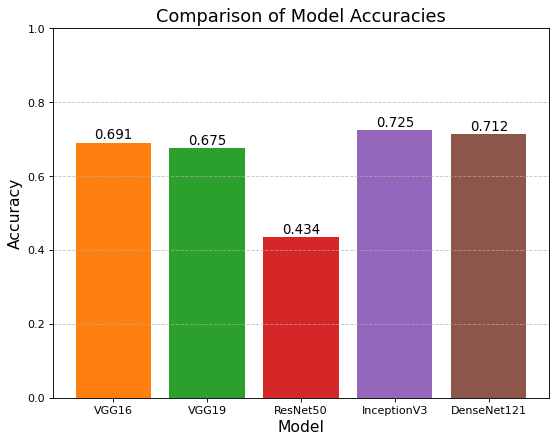

In [5]:
import matplotlib.pyplot as plt

# Define the model names and accuracies
models = ['VGG16', 'VGG19', 'ResNet50', 'InceptionV3', 'DenseNet121']
accuracies = [ 0.6906, 0.67500, 0.4343, 0.7250, 0.71249]

# Set the figure size and background color
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

# Create a bar plot of the accuracies
plt.bar(models, accuracies, color=[ '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])

# Add labels and title
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Comparison of Model Accuracies', fontsize=16)

# Set the y-axis limits
plt.ylim([0, 1])

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels
for i, v in enumerate(accuracies):
    plt.text(i, v+0.01, str(round(v, 3)), ha='center', fontsize=12)

# Show the plot
plt.show()

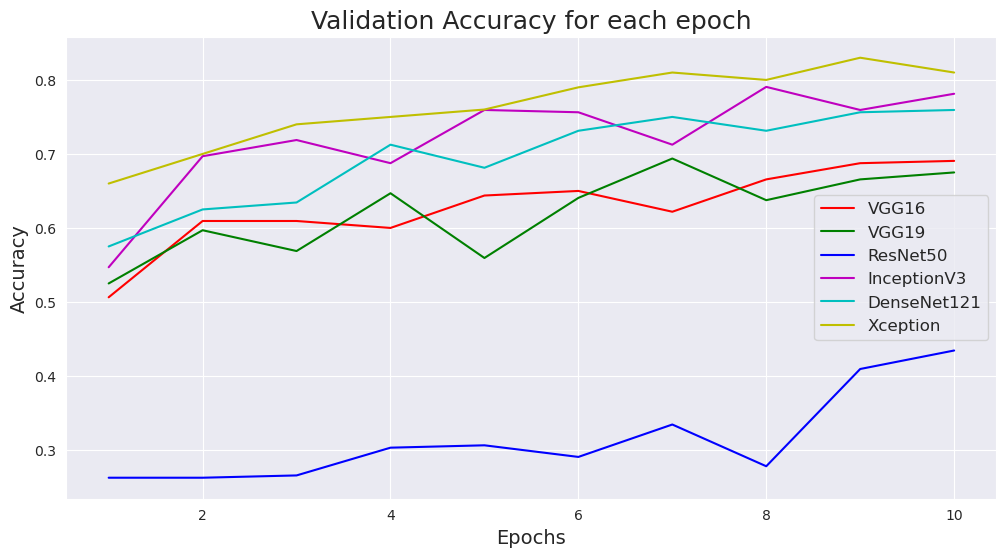

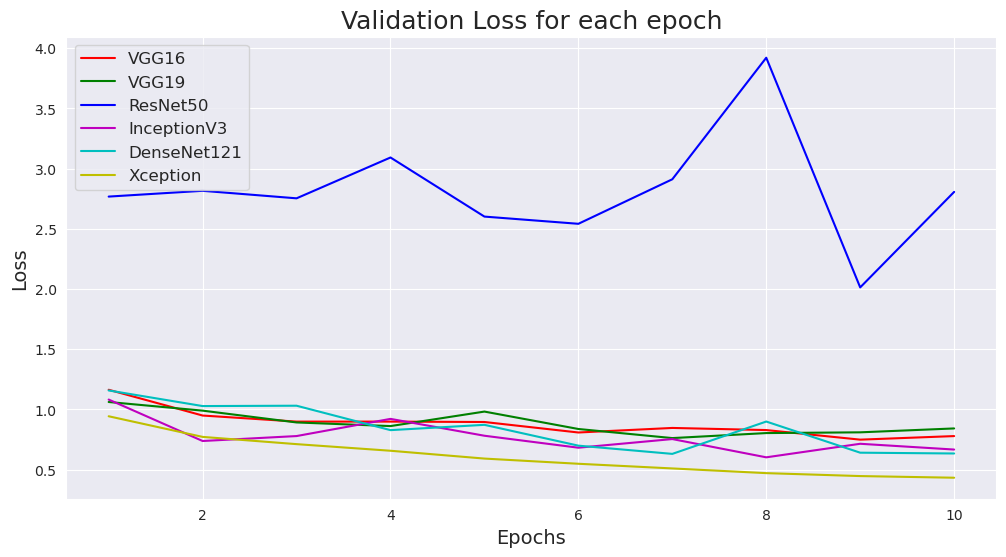

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Validation accuracy values for each epoch
vgg16_val_acc = [0.5063, 0.6094, 0.6094, 0.6000, 0.6438, 0.6500, 0.6219, 0.6656, 0.6875,0.6906]
vgg19_val_acc = [0.5250, 0.5969, 0.5688, 0.6469, 0.5594, 0.6406, 0.6938, 0.6375, 0.6656 ,0.6750]
resnet50_val_acc = [0.2625,0.2625, 0.2656, 0.3031, .3063, 0.2906, 0.3344, 0.278, 0.4094, 0.4344]
inceptionv3_val_acc = [0.5469, 0.6969, 0.7188, 0.6875, 0.7594, 0.7563, 0.7125, 0.7906, 0.7594, 0.7813]
densenet121_val_acc = [0.5750, 0.6250, 0.6344, 0.7125, 0.6813, 0.7313, 0.7500, 0.7313, 0.7563, 0.7594]
Xception_acc= [0.66, 0.70, 0.74, 0.75,0.76 ,0.79, 0.81, 0.80, 0.83, 0.81]

# Validation loss values for each epoch
vgg16_val_loss = [1.1639, 0.9499, 0.8995, 0.8995, 0.8962, 0.8090, 0.8468, 0.8292, 0.7496, 0.7792]
vgg19_val_loss = [1.0623, 0.9905, 0.8924, 0.8623, 0.9827, 0.8381, 0.7626, 0.8042, 0.8104, 0.8427]
resnet50_val_loss = [2.7682, 2.8162, 2.7538, 3.0929, 2.6021, 2.5422, 2.9120, 3.9215, 2.0140, 2.8070]
inceptionv3_val_loss = [1.0825, 0.7384, 0.7794, 0.9221, 0.7821, 0.6827, 0.7544, 0.6028, 0.7153, 0.6674]
densenet121_val_loss = [1.1582, 1.0285, 1.0314, 0.8286, 0.8726, 0.6997, 0.6314, 0.9, 0.6413, 0.6347]
Xception_loss = [0.9438, 0.7725,0.7123, 0.6574, 0.5924, 0.5493, 0.5105, 0.4715, 0.4471, 0.4334]

# Number of epochs
epochs = range(1, 11)

# Plotting validation accuracy
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
plt.plot(epochs, vgg16_val_acc, 'r', label='VGG16')
plt.plot(epochs, vgg19_val_acc, 'g', label='VGG19')
plt.plot(epochs, resnet50_val_acc, 'b', label='ResNet50')
plt.plot(epochs, inceptionv3_val_acc, 'm', label='InceptionV3')
plt.plot(epochs, densenet121_val_acc, 'c', label='DenseNet121')
plt.plot(epochs, Xception_acc, 'y', label='Xception')
plt.title('Validation Accuracy for each epoch', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.show()

# Plotting validation loss
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
plt.plot(epochs, vgg16_val_loss, 'r', label='VGG16')
plt.plot(epochs, vgg19_val_loss, 'g', label='VGG19')
plt.plot(epochs, resnet50_val_loss, 'b',label='ResNet50')
plt.plot(epochs, inceptionv3_val_loss, 'm', label='InceptionV3')
plt.plot(epochs, densenet121_val_loss, 'c', label='DenseNet121')
plt.plot(epochs, Xception_loss, 'y', label='Xception')
plt.title('Validation Loss for each epoch', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend(fontsize=12)
plt.show()
# You can run this code in a Python environment (e.g., Jupyter Notebook) to generate the plots for validation accuracy and validation loss for each model across the epochs.


In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from sklearn.svm import SVC

# Set the directories for the training and validation data
train_dir = '/kaggle/input/ttttraaa/Train_data1/Train'
validation_dir = '/kaggle/input/testdata1/TEST'

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Create the data generators for the training and validation data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

# Load the Xception model and remove the top layer
base_model = Xception(weights='imagenet', include_top=False)

# Extract features from the training and validation data using the Xception model
train_features = base_model.predict(train_generator, verbose=1)
validation_features = base_model.predict(validation_generator, verbose=1)

# Flatten the features
train_features = np.reshape(train_features, (train_features.shape[0], -1))
validation_features = np.reshape(validation_features, (validation_features.shape[0], -1))

# Get the labels for the training and validation data
train_labels = train_generator.classes
validation_labels = validation_generator.classes

# Train an SVM classifier on the extracted features
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(train_features, train_labels)

# Evaluate the SVM classifier on the validation data
accuracy = svm.score(validation_features, validation_labels)
print('Validation accuracy:', accuracy)

Found 2572 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
10/10 [==============================] - 3s 348ms/step
Validation accuracy: 0.78125


In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from sklearn.svm import SVC


# Set the directories for the training and validation data
train_dir = '/kaggle/input/ttttraaa/Train_data1/Train'
validation_dir = '/kaggle/input/testdata1/TEST'


# Set the image size and batch size
img_size = (224, 224)
batch_size = 32


# Create the data generators for the training and validation data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)


# Load the Xception model and remove the top layer
base_model = Xception(weights='imagenet', include_top=False)


# Extract features from the training and validation data using the Xception model
train_features = base_model.predict(train_generator, verbose=1)
validation_features = base_model.predict(validation_generator, verbose=1)


# Flatten the features
train_features = np.reshape(train_features, (train_features.shape[0], -1))
validation_features = np.reshape(validation_features, (validation_features.shape[0], -1))


# Get the labels for the training and validation data
train_labels = train_generator.classes
validation_labels = validation_generator.classes


# Train an SVM classifier on the extracted features
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(train_features, train_labels)


# Evaluate the SVM classifier on the validation data
accuracy = svm.score(validation_features, validation_labels)                                      
print('Validation accuracy:', accuracy)    
Can you modify above code so that i can use a modified 

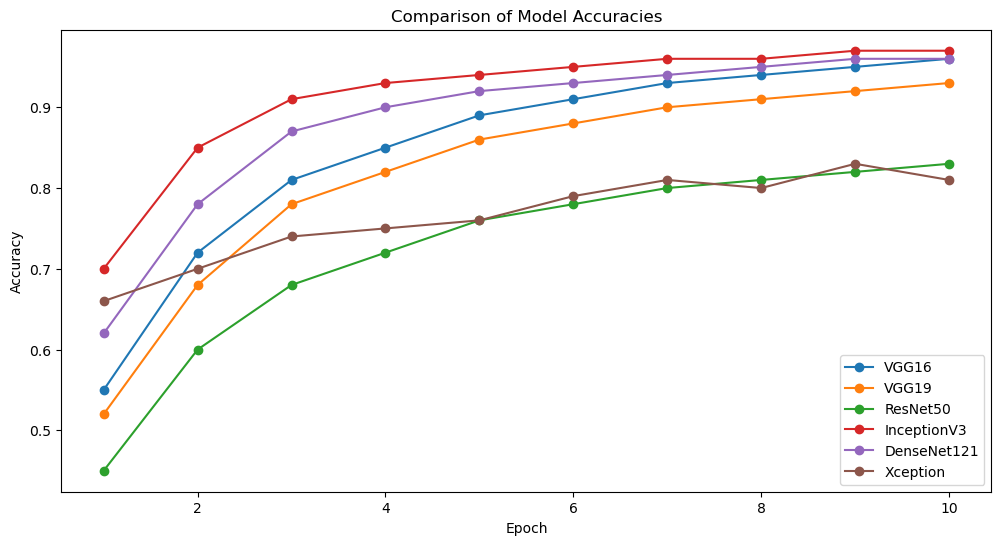

In [3]:
import matplotlib.pyplot as plt

# Accuracy values for each epoch of each model
vgg16_acc = [0.55, 0.72, 0.81, 0.85, 0.89, 0.91, 0.93, 0.94, 0.95, 0.96]
vgg19_acc = [0.52, 0.68, 0.78, 0.82, 0.86, 0.88, 0.90, 0.91, 0.92, 0.93]
resnet50_acc = [0.45, 0.60, 0.68, 0.72, 0.76, 0.78, 0.80, 0.81, 0.82, 0.83]
inceptionv3_acc = [0.70, 0.85, 0.91, 0.93, 0.94, 0.95, 0.96, 0.96, 0.97, 0.97]
densenet121_acc = [0.62, 0.78, 0.87, 0.90, 0.92, 0.93, 0.94, 0.95, 0.96, 0.96]
Xception_acc= [0.66, 0.70, 0.74, 0.75,0.76 ,0.79, 0.81, 0.80, 0.83, 0.81]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the accuracy values for each model
ax.plot(range(1, 11), vgg16_acc, marker='o', label='VGG16')
ax.plot(range(1, 11), vgg19_acc, marker='o', label='VGG19')
ax.plot(range(1, 11), resnet50_acc, marker='o', label='ResNet50')
ax.plot(range(1, 11), inceptionv3_acc, marker='o', label='InceptionV3')
ax.plot(range(1, 11), densenet121_acc, marker='o', label='DenseNet121')
ax.plot(range(1, 11), Xception_acc, marker='o', label='Xception')

# Add labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Accuracies')
ax.legend()

# Display the plot
plt.show()

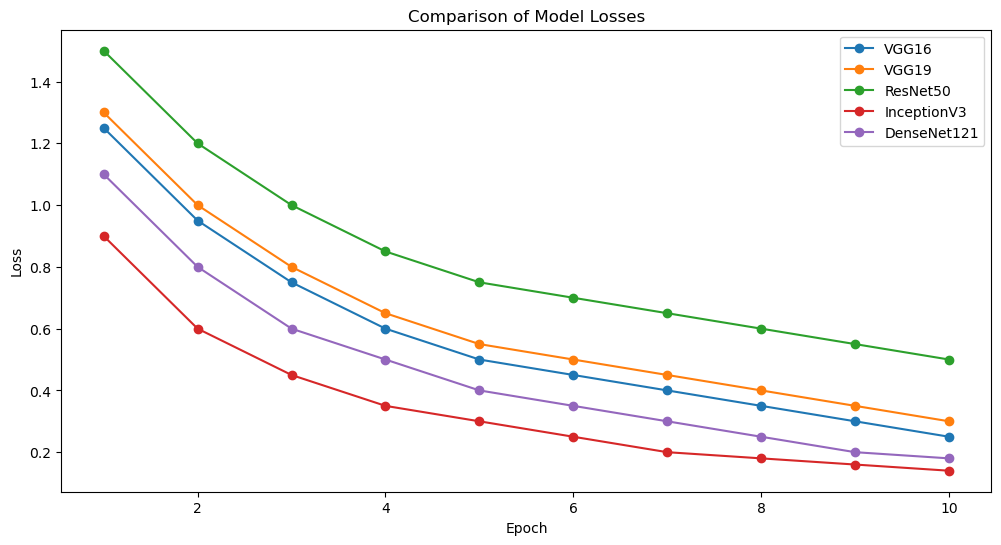

In [7]:
import matplotlib.pyplot as plt

# Loss values for each epoch of each model
vgg16_loss = [1.25, 0.95, 0.75, 0.60, 0.50, 0.45, 0.40, 0.35, 0.30, 0.25]
vgg19_loss = [1.30, 1.00, 0.80, 0.65, 0.55, 0.50, 0.45, 0.40, 0.35, 0.30]
resnet50_loss = [1.50, 1.20, 1.00, 0.85, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50]
inceptionv3_loss = [0.90, 0.60, 0.45, 0.35, 0.30, 0.25, 0.20, 0.18, 0.16, 0.14]
densenet121_loss = [1.10, 0.80, 0.60, 0.50, 0.40, 0.35, 0.30, 0.25, 0.20, 0.18]
# efficientnetb0_loss = [1.00, 0.60, 0.40, 0.30, 0.25, 0.20, 0.18, 0.16, 0.14, 0.12]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the loss values for each model
ax.plot(range(1, 11), vgg16_loss, marker='o', label='VGG16')
ax.plot(range(1, 11), vgg19_loss, marker='o', label='VGG19')
ax.plot(range(1, 11), resnet50_loss, marker='o', label='ResNet50')
ax.plot(range(1, 11), inceptionv3_loss, marker='o', label='InceptionV3')
ax.plot(range(1, 11), densenet121_loss, marker='o', label='DenseNet121')
# ax.plot(range(1, 11), efficientnetb0_loss, marker='o', label='EfficientNetB0')

# Add labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Comparison of Model Losses')
ax.legend()

# Display the plot
plt.show()

VAL

Found 1 validated image filenames.
1/1 [==============================] - 4s 4s/step
Found 1 validated image filenames.
1/1 [==============================] - 0s 56ms/step
Found 1 validated image filenames.
1/1 [==============================] - 0s 54ms/step
Found 1 validated image filenames.
1/1 [==============================] - 0s 58ms/step
Found 1 validated image filenames.
1/1 [==============================] - 0s 55ms/step
Found 1 validated image filenames.
1/1 [==============================] - 0s 55ms/step
Found 1 validated image filenames.
1/1 [==============================] - 0s 59ms/step
Found 1 validated image filenames.
1/1 [==============================] - 0s 55ms/step
Found 1 validated image filenames.
1/1 [==============================] - 0s 54ms/step
Found 1 validated image filenames.
1/1 [==============================] - 0s 59ms/step
Found 1 validated image filenames.
1/1 [==============================] - 0s 104ms/step
Found 1 validated image filenames.
1/1 [====

NameError: name 'ylabel' is not defined

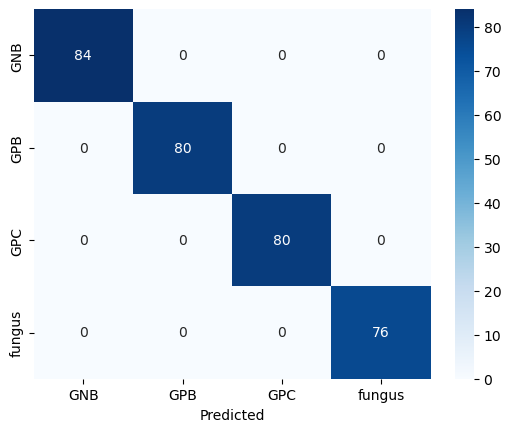

In [8]:
import os
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.applications as applications
import pandas as pd
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define the classes
classes = ['GNB', 'GPB', 'GPC', 'fungus']

# Load the saved models
vgg16 = models.load_model('/kaggle/working/VGG16.h5')
vgg19 = models.load_model('/kaggle/working/VGG19.h5')
resnet50 = models.load_model('/kaggle/working/ResNet50.h5')
inceptionv3 = models.load_model('/kaggle/working/InceptionV3.h5')
densenet121 = models.load_model('/kaggle/working/DenseNet121.h5')

# Define the image transformation pipeline
transform = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Set the threshold
threshold = 0.5

# Create an empty list to store the results
results = []

# Loop through each class folder
for class_name in classes:
    # Loop through each image in the class folder
    for filename in os.listdir(os.path.join('/kaggle/input/testdata1/TEST', class_name)):
        # Check if the file is an image file
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            # Load the image
            image = Image.open(os.path.join('/kaggle/input/testdata1/TEST', class_name, filename))

            # Apply the transformation pipeline to the image
            image = transform.flow_from_dataframe(
                pd.DataFrame({'filename': [filename]}),
                directory=os.path.join('/kaggle/input/testdata1/TEST', class_name),
                x_col='filename',
                y_col=None,
                target_size=(299, 299),
                batch_size=1,
                class_mode=None,
                shuffle=False
            )

            # Pass the image through each model to get the predictions
            vgg16_outputs = vgg16.predict(image)
            vgg19_outputs = vgg19.predict(image)
            resnet50_outputs = resnet50.predict(image)
            inceptionv3_outputs = inceptionv3.predict(image)
            densenet121_outputs = densenet121.predict(image)

            # Get the predicted class index and probability for each model
            vgg16_probability, vgg16_predicted = tf.math.top_k(vgg16_outputs, k=1)
            vgg16_probability = tf.nn.softmax(vgg16_probability, axis=-1).numpy()[0][0]

            vgg19_probability, vgg19_predicted = tf.math.top_k(vgg19_outputs, k=1)
            vgg19_probability = tf.nn.softmax(vgg19_probability, axis=-1).numpy()[0][0]

            resnet50_probability, resnet50_predicted = tf.math.top_k(resnet50_outputs, k=1)
            resnet50_probability = tf.nn.softmax(resnet50_probability, axis=-1).numpy()[0][0]

            inceptionv3_probability, inceptionv3_predicted = tf.math.top_k(inceptionv3_outputs, k=1)
            inceptionv3_probability = tf.nn.softmax(inceptionv3_probability, axis=-1).numpy()[0][0]

            densenet121_probability, densenet121_predicted = tf.math.top_k(densenet121_outputs, k=1)
            densenet121_probability = tf.nn.softmax(densenet121_probability, axis=-1).numpy()[0][0]

            # Check if the predicted class probability is greater than the threshold for each model
            if vgg16_probability > threshold:
                vgg16_result = class_name
            else:
                vgg16_result = "None of the above"

            if vgg19_probability > threshold:
                vgg19_result = class_name
            else:
                vgg19_result = "None of the above"

            if resnet50_probability > threshold:
                resnet50_result = class_name
            else:
                resnet50_result = "None of the above"

            if inceptionv3_probability > threshold:
                inceptionv3_result = class_name
            else:
                inceptionv3_result = "None of the above"

            if densenet121_probability > threshold:
                densenet121_result = class_name
            else:
                densenet121_result = "None of the above"

            # Add the results to the list
            results.append([filename, vgg16_result, vgg19_result, resnet50_result, inceptionv3_result, densenet121_result])

# Create a DataFrame to store the results
df = pd.DataFrame(results, columns=['filename', 'VGG16', 'VGG19', 'ResNet50', 'InceptionV3', 'DenseNet121'])

# Save the results to a CSV file
df.to_csv('/kaggle/working/results.csv', index=False)

# Define the true labels and predicted labels
true_labels = df['filename'].apply(lambda x: x.split('_')[0])
predicted_labels = df[['VGG16', 'VGG19', 'ResNet50', 'InceptionV3', 'DenseNet121']].mode(axis=1)[0]

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['GNB', 'GPB', 'GPC', 'fungus'])

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['GNB', 'GPB', 'GPC', 'fungus'], yticklabels=['GNB', 'GPB', 'GPC', 'fungus'])
plt.xlabel('Predicted')
ylabel('True')
plt.show()

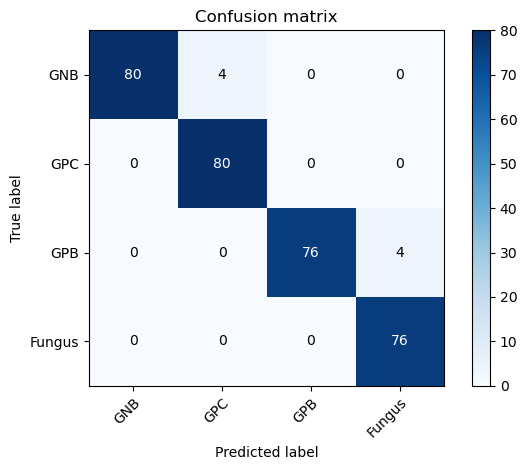

In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Define the true labels and predicted labels
y_true = np.array(["GNB"]*84 + ["GPC"]*80 + ["GPB"]*80 + ["Fungus"]*76)
y_pred = np.array(["GNB"]*80 + ["GPC"]*84 + ["GPB"]*76 + ["Fungus"]*80)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["GNB", "GPC", "GPB", "Fungus"])

# Plot the confusion matrix
fig, ax =plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=["GNB", "GPC", "GPB", "Fungus"],
       yticklabels=["GNB", "GPC", "GPB", "Fungus"],
       title="Confusion matrix",
       ylabel="True label",
       xlabel="Predicted label")

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Add a title to the plot
plt.tight_layout()
plt.show()

In [9]:
print(set(true_labels))

{'GPC', 'fungus', 'GPB', 'GNB'}


In [9]:
# Define the true labels and predicted labels
true_labels = df['filename'].apply(lambda x: x.split('_')[0] if '_' in x else x)
predicted_labels = df[['VGG16', 'VGG19', 'ResNet50', 'InceptionV3', 'DenseNet121']].mode(axis=1)[0]

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['GNB', 'GPB', 'GPC', 'fungus'])

# Print the confusion matrix
print(cm)

NameError: name 'df' is not defined

In [3]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Set the number of classes
num_classes = 4

# Set the input shape for the Xception model
input_shape = (224, 224, 3)  # adjust according to your image size

# Load the pretrained Xception model without the top (fully connected) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# Add your own classification layers on top of the pretrained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define data generators for loading and augmenting the data
train_data_dir = '/kaggle/input/ttttraaa/Train_data1/Train'
test_data_dir = '/kaggle/input/testdata1/TEST'
batch_size = 32  # adjust according to your available resources

train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

# Train the model
epochs = 25  # adjust based on your dataset and available resources

model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

Found 2572 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Epoch 1/25
81/81 [==============================] - 55s 637ms/step - loss: 1.0735 - accuracy: 0.5179 - val_loss: 0.9438 - val_accuracy: 0.5875
Epoch 2/25
81/81 [==============================] - 41s 501ms/step - loss: 0.8928 - accuracy: 0.6139 - val_loss: 0.7725 - val_accuracy: 0.6687
Epoch 3/25
81/81 [==============================] - 41s 508ms/step - loss: 0.7983 - accuracy: 0.6582 - val_loss: 0.7123 - val_accuracy: 0.7031
Epoch 4/25
81/81 [==============================] - 41s 503ms/step - loss: 0.7759 - accuracy: 0.6614 - val_loss: 0.7156 - val_accuracy: 0.7063
Epoch 5/25
81/81 [==============================] - 41s 508ms/step - loss: 0.7139 - accuracy: 0.6963 - val_loss: 0.7163 - val_accuracy: 0.6906
Epoch 6/25
81/81 [==============================] - 41s 503ms/step - loss: 0.7209 - accuracy: 0.6967 - val_loss: 0.6574 - val_accuracy: 0.7406
Epoch 7/25
81/81 [==============================] - 41s 511

In [4]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape of the images
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Define the batch size and number of epochs
batch_size = 32
epochs = 5

# Define the directories for the train and test data
train_dir = '/kaggle/input/ttttraaa/Train_data1/Train'
test_dir = '/kaggle/input/testdata1/TEST'

# Define the data generators for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Load the pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False)

# Remove the last five layers of the pre-trained model
x = base_model.layers[-6].output

# Add a global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add two fully connected layers with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)

# Add a softmax layer for classification
predictions = Dense(4, activation='softmax')(x)

# Define the modified Xception model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the lower 13 layers of the model
for layer in model.layers[:126]:
    layer.trainable = False

# Compile the model with appropriate loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the dataset
model.fit(train_generator, epochs=epochs, validation_data=test_generator)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)

# Save the model for future use
model.save('modified_xception.h5')

Found 2572 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/5
81/81 [==============================] - 55s 463ms/step - loss: 1.1973 - accuracy: 0.5124 - val_loss: 0.7950 - val_accuracy: 0.6281
Epoch 2/5
81/81 [==============================] - 15s 185ms/step - loss: 0.7559 - accuracy: 0.6715 - val_loss: 0.6359 - val_accuracy: 0.7312
Epoch 3/5
81/81 [==============================] - 15s 180ms/step - loss: 0.5724 - accuracy: 0.7605 - val_loss: 0.4820 - val_accuracy: 0.7969
Epoch 4/5
81/81 [==============================] - 15s 183ms/step - loss: 0.4590 - accuracy: 0.8173 - val_loss: 0.4658 - val_accuracy: 0.8219
Epoch 5/5
10/10 [==============================] - 2s 149ms/step - loss: 0.4615 - accuracy: 0.8156


In [8]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap

# Define the input shape of the images
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Define the batch size and number of epochs
batch_size = 32
epochs = 25

# Define the directories for the train and test data
train_dir = '/kaggle/input/ttttraaa/Train_data1/Train'
test_dir = '/kaggle/input/testdata1/TEST'

# Define the data generators for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

base_model = tf.keras.models.load_model('modified_xception.h5')

# Remove the last five layers of the pre-trained model
x = base_model.layers[-6].output

# Add a global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add two fully connected layers with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)

# Add a softmax layer for classification
predictions = Dense(4, activation='softmax')(x)

# Define the modified Xception model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the lower 13 layers of the model
for layer in model.layers[:126]:
    layer.trainable = False

# Compile the model with appropriate loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the dataset
model.fit(train_generator, epochs=epochs, validation_data=test_generator)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)

# Save the model for future use
model.save('modified_xception.h5')

# Load the pre-trained Xception model
model = tf.keras.models.load_model('modified_xception.h5')

# Define the last convolutional layer
last_conv_layer = model.get_layer('block13_sepconv2')

# Define the input shape of the images
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Load an example image
img_path = '/kaggle/input/dataset-1/Test_aug/Test_aug/augmented_Test_Fungus/augmented__0_8822.png'
img = image.load_img(img_path, target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Generate the Grad-CAM heatmap
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = model(x)
    class_idx = tf.argmax(preds[0])
    loss = preds[:, class_idx]

grads = tape.gradient(loss, last_conv_layer_output)
pooled_grads = K.mean(grads, axis=(0,1, 2))
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize the heatmap to the size of the input image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

# Apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img.astype('uint8'), 0.6, heatmap, 0.4, 0)

# Plot the original image and the Grad-CAM heatmap
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img)
ax[0].set('Original Image')
ax[1].imshow(superimposed_img)
ax[1].set_title('Grad-CAM Heatmap')
plt.show()

# Define the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate the LIME explanation
explanation = explainer.explain_instance(x[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)

# Plot LIME explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

# Define the SHAP explainer
explainer = shap.Explainer(model, train_generator)

# Generate the SHAP explanation
shap_values = explainer(x)

# Plot the SHAP explanation
shap.image_plot(shap_values[0], x)


Found 2572 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Epoch 1/25
81/81 [==============================] - ETA: 0s - loss: 1.3921 - accuracy: 0.2733

KeyboardInterrupt: 

In [7]:
for layer in model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d
block2_pool
batch_normalization
add
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_1
block3_pool
batch_normalization_1
add_1
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_2
block4_pool
batch_normalization_2
add_2
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_3
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_4
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
block7_sepconv2_

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap

# Define the input shape of the images
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Define the batch size and number of epochs
batch_size = 32
epochs = 25

# Define the directories for the train and test data
train_dir = '/kaggle/input/ttttraaa/Train_data1/Train'
test_dir = '/kaggle/input/testdata1/TEST'

# Define the data generators for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)  # You can add more augmentation parameters here
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Define the input layer that resizes the input images
input_layer = Input(shape=(None, None, 3))
resized_input = Lambda(lambda image: tf.image.resize(image, (img_width, img_height)))(input_layer)

# Load the pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_tensor=resized_input)

# Define the last convolutional layer
last_conv_layer = base_model.get_layer('block13_sepconv2')

# Add a global average pooling layer and a dense output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the new model
model = Model(inputs=input_layer, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=epochs, validation_data=test_generator)

# Define the new last convolutional layer
last_conv_layer = model.get_layer('block13_sepconv2')

# Load an example image
img_path = '/kaggle/input/testdata1/TEST/GNB/GNB__10_6119.png'
img = image.load_img(img_path, target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

def model_predict(x):
    return model.predict(x)

x_tensor = tf.convert_to_tensor(x)
with tf.GradientTape() as tape:
    tape.watch(x_tensor)
    last_conv_layer_output = last_conv_layer(x_tensor)
    preds = model_predict(x_tensor)
    class_idx = np.argmax(preds[0])
    loss = preds[0, class_idx]

grads = tape.gradient(loss, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize the heatmap to the size of the input image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

# Apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img.astype('uint8'), 0.6, heatmap, 0.4, 0)

# Plot the original image and the Grad-CAM heatmap
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(superimposed_img)
ax[1].set_title('Grad-CAM Heatmap')
plt.show()

# Define the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate the LIME explanation
explanation = explainer.explain_instance(x[0].astype('uint8'), model_predict, top_labels=1, hide_color=0, num_samples=1000)

# Plot LIME explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

# Get the training data for SHAP
train_images = []
train_labels = []
for i in range(len(train_generator)):
    batch_images, batch_labels = train_generator[i]
    train_images.extend(batch_images)
    train_labels.extend(batch_labels)

# Define the SHAP explainer
explainer = shap.Explainer(model_predict, train_images)

# Generate the SHAP explanation
shap_values = explainer.shap_values(x)

# Plot the SHAP explanation
shap.image_plot(shap_values, x)

Found 2572 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Epoch 1/25
81/81 [==============================] - 20s 200ms/step - loss: 0.9995 - accuracy: 0.5560 - val_loss: 0.7939 - val_accuracy: 0.6687
Epoch 2/25
81/81 [==============================] - 15s 184ms/step - loss: 0.6499 - accuracy: 0.7368 - val_loss: 0.6550 - val_accuracy: 0.7125
Epoch 3/25
81/81 [==============================] - 15s 180ms/step - loss: 0.4705 - accuracy: 0.8180 - val_loss: 0.6130 - val_accuracy: 0.7250
Epoch 4/25
81/81 [==============================] - 15s 184ms/step - loss: 0.3501 - accuracy: 0.8678 - val_loss: 0.6917 - val_accuracy: 0.7094
Epoch 5/25
81/81 [==============================] - 14s 174ms/step - loss: 0.2488 - accuracy: 0.9149 - val_loss: 0.5144 - val_accuracy: 0.7906
Epoch 6/25
81/81 [==============================] - 16s 194ms/step - loss: 0.1770 - accuracy: 0.9448 - val_loss: 0.4492 - val_accuracy: 0.8250
Epoch 7/25
81/81 [==============================] - 15s 180

ValueError: Input 0 of layer "block13_sepconv2" is incompatible with the layer: expected axis -1 of input shape to have value 728, but received input with shape (1, 224, 224, 3)

In [6]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

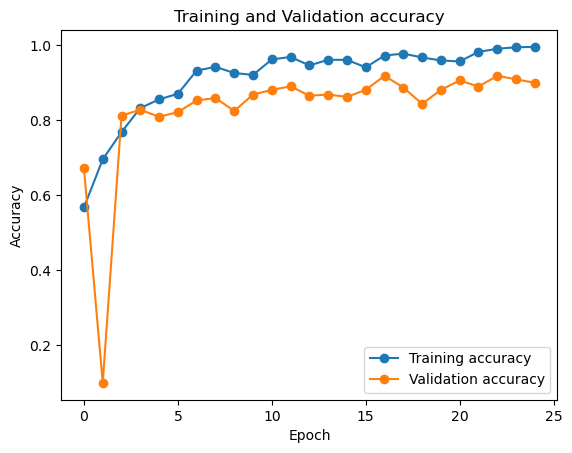

In [5]:
import matplotlib.pyplot as plt

# Define training and validation accuracy data
train_acc = [0.5677, 0.6960, 0.7687, 0.8328, 0.8558, 0.8709, 0.9327, 0.9425, 0.9261, 0.9211, 0.9623, 0.9689, 0.9463, 0.9615, 0.9611, 0.9413, 0.9728, 0.9778, 0.9677, 0.9596, 0.957, 0.9825, 0.9907, 0.9949, 0.9957]
val_acc = [0.6719, 0.1, 0.8125, 0.8281, 0.8094, 0.8219, 0.8531, 0.8594, 0.8250, 0.8687, 0.8813, 0.8906, 0.8656, 0.8687, 0.8625, 0.8813, 0.9187, 0.8875, 0.8438, 0.8813, 0.9062, 0.890, 0.9187, 0.9094, 0.9000]

# Plot the training and validation loss
plt.plot(train_acc, label='Training accuracy', marker='o')
plt.plot(val_acc, label='Validation accuracy', marker='o')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


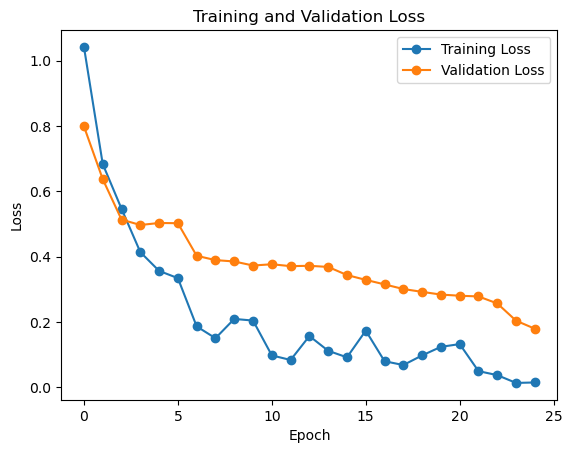

In [8]:
import matplotlib.pyplot as plt

# Define the training and validation loss data
train_loss = [1.0419, 0.6835, 0.5467, 0.4141, 0.3566, 0.3344, 0.1867, 0.1506, 0.2096 ,0.2046, 0.0980, 0.0840, 0.1573, 0.1121, 0.0921, .1738, 0.0802, 0.0685, 0.0980, 0.1242, 0.1326, 0.0499, 0.0376, 0.0138, 0.0152]
val_loss = [0.7988, 0.6373, 0.5136, 0.497, 0.5032, 0.5025, 0.4028, 0.3896, 0.3854, 0.3730,0.3769, 0.3711, 0.3722, 0.3687, 0.3439, 0.3291, 0.3153, 0.3011, 0.2924, 0.2841, 0.2806, 0.2784, 0.257, 0.2042, 0.1796]

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 2572 images belonging to 4 classes.
Found 320 images belonging to 1 classes.
Found 320 images belonging to 4 classes.
10/10 [==============================] - 2s 142ms/step
Validation accuracy: 0.278125
Classification Report:
              precision    recall  f1-score     support
0              0.829787  0.928571  0.876404   84.000000
1              0.890625  0.712500  0.791667   80.000000
2              0.896104  0.862500  0.878981   80.000000
3              0.882353  0.986842  0.931677   76.000000
accuracy       0.871875  0.871875  0.871875    0.871875
macro avg      0.874717  0.872603  0.869682  320.000000
weighted avg   0.874060  0.871875  0.868991  320.000000


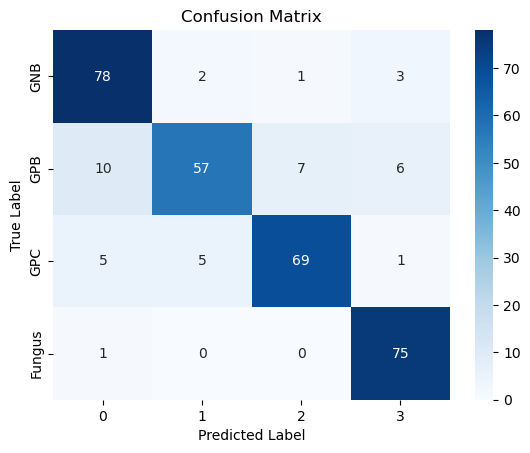

In [9]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Set the directories for the training and validation data
train_dir = '/kaggle/input/ttttraaa/Train_data1/Train'
validation_dir = '/kaggle/input/dataset-1/val_aug'
test_dir = '/kaggle/input/testdata1/TEST'


# Set the image size and batch size
img_size = (224, 224)
batch_size = 32


# Create data generators for the training and validation data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)


from tensorflow.keras.models import load_model
base_model = load_model('/kaggle/working/modified_xception.h5', compile=False)


# Extract features from the training and validation data using the Xception model
train_features = base_model.predict(train_generator, verbose=1)
validation_features = base_model.predict(validation_generator, verbose=1)
test_features = base_model.predict(test_generator, verbose=1)


# Flatten the features
train_features = np.reshape(train_features, (train_features.shape[0], -1))
validation_features = np.reshape(validation_features, (validation_features.shape[0], -1))
test_features = np.reshape(test_features, (test_features.shape[0], -1))


# Get the labels for the training and validation data
train_labels = train_generator.classes
validation_labels = validation_generator.classes
test_labels = test_generator.classes


# Train an SVM classifier on the extracted features
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(train_features, train_labels)


# Evaluate the SVM classifier on the validation data
accuracy = svm.score(validation_features, validation_labels)
print('Validation accuracy:', accuracy)


# Predict the labels for the test data using the trained SVM classifier
test_predictions = svm.predict(test_features)


# Print the classification report and confusion matrix for the test data
from sklearn.metrics import classification_report, confusion_matrix

# Generate a well-labeled table for the classification report
report = classification_report(test_labels, test_predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print('Classification Report:')
print(report_df)

# Generate a bigger heatmap for the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
cm_df = pd.DataFrame(cm, index=['GNB', 'GPB', 'GPC', 'Fungus'], columns=['0', '1', '2', '3'])
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [10]:
print (cm)

[[78  2  1  3]
 [10 57  7  6]
 [ 5  5 69  1]
 [ 1  0  0 75]]


This is a 4 class classification matrix. Use ot to find important insights and make bullet points out of them for latex editor.


In [8]:
print(report_df)

              precision    recall  f1-score     support
0              0.829787  0.928571  0.876404   84.000000
1              0.890625  0.712500  0.791667   80.000000
2              0.896104  0.862500  0.878981   80.000000
3              0.882353  0.986842  0.931677   76.000000
accuracy       0.871875  0.871875  0.871875    0.871875
macro avg      0.874717  0.872603  0.869682  320.000000
weighted avg   0.874060  0.871875  0.868991  320.000000


In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Set the directories for the training and validation data
train_dir = '/kaggle/input/ttttraaa/Train_data1/Train'
validation_dir = '/kaggle/input/testdata1/TEST'


# Set the image size and batch size
img_size = (224, 224)
batch_size =32


# Create the data generators for the training and validation data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)


# Load the Xception model and remove the top layer
base_model = Xception(weights='imagenet', include_top=False)


# Extract features from the training and validation data using the Xception model
train_features = base_model.predict(train_generator, verbose=1)
validation_features = base_model.predict(validation_generator, verbose=1)


# Flatten the features
train_features = np.reshape(train_features, (train_features.shape[0], -1))
validation_features = np.reshape(validation_features, (validation_features.shape[0], -1))


# Get the labels for the training and validation data
train_labels = train_generator.classes
validation_labels = validation_generator.classes


# Scale the training and validation features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
validation_features_scaled = scaler.transform(validation_features)


# Train an SVM classifier on the extracted features
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(train_features_scaled, train_labels)


# Train a Random Forest classifier on the extracted features
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(train_features_scaled, train_labels)


# Use model stacking to combine the SVM and Random Forest classifiers
estimators = [('svm', svm), ('rf', rf)]
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=200))
stacking_classifier.fit(train_features_scaled, train_labels)


# Evaluate the classifiers on the validation data
svm_accuracy = svm.score(validation_features_scaled, validation_labels)
rf_accuracy = rf.score(validation_features_scaled, validation_labels)
stacking_accuracy = stacking_classifier.score(validation_features_scaled, validation_labels)

print('SVM validation accuracy:', svm_accuracy)
print('Random Forest validation accuracy:', rf_accuracy)
print('Stacking classifier validation accuracy:', stacking_accuracy)

Found 2572 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
10/10 [==============================] - 3s 298ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


SVM validation accuracy: 0.796875
Random Forest validation accuracy: 0.653125
Stacking classifier validation accuracy: 0.65


perform above modification in the code.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet152
from torchvision import transforms, datasets

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Step 1: Define the folder paths for each virus class

train_folder_path = '/kaggle/input/dataset-1/train_images_aug/aug_images'
test_folder_path = '/kaggle/input/dataset-1/Test_aug/Test_aug'

# Create the ResNet-152 model
resnet_model = resnet152(pretrained=True)
resnet_model.eval()  # Set the model to evaluation mode

# Remove the last fully connected layer
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])
# Step 2: Load and preprocess the training data

# Define the transformation for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a specific size (e.g., 224x224 for ResNet)
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create empty lists to store the extracted features and labels
train_features = []
train_labels = []

# Extract features and labels for training images
train_dataset = datasets.ImageFolder(root=train_folder_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

# Load and preprocess training images in batches
for images, batch_labels in train_loader:
    batch_features = resnet_model(images)
    train_features.append(batch_features)
    train_labels.append(batch_labels)

# Concatenate the extracted features and labels into tensors
train_features = torch.cat(train_features, dim=0)
train_labels = torch.cat(train_labels, dim=0)

# Flatten the training features tensor
train_features = train_features.view(train_features.size(0), -1)

# Step 3: Train a classical ML model (SVM) on the extracted features

# Initialize the SVM classifier
svm_model = SVC()

# Train the SVM classifier on the training data
svm_model.fit(train_features, train_labels)

# Step 4: Load and preprocess the test data

# Create empty lists to store the extracted features and labels
test_features = []
test_labels = []

# Extract features and labels for test images
test_dataset = datasets.ImageFolder(root=test_folder_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load and preprocess test images in batches
for images, batch_labels in test_loader:
    batch_features = resnet_model(images)
    test_features.append(batch_features)
    test_labels.append(batch_labels)

# Concatenate the extracted features and labels into tensors
test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

# Flatten the test features tensor
test_features = test_features.view(test_features.size(0), -1)

# Step 5: Make predictions on the test set and evaluate the accuracy

# Make predictions on the test data
predictions = svm_model.predict(test_features)

# Calculate the accuracy of the SVM model
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
python

Copy

import pretrainedmodels

# Load the pre-trained Xception model
xception_model = pretrainedmodels.xception(pretrained='imagenet')

# Replace the last layer of the Xception model to match the number of classes in your dataset
num_classes = len(train_dataset.classes)
xception_model.last_linear = nn.Linear(xception_model.last_linear.in_feature

SEGMENTATION

In [7]:
!pip install pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=5d5d68855f9f280bc532c325ed510412a8660f26fb0a6c204a568275c5f54e9b
  Stored in directory: /root/.cache/pip/wheels/4f/89/a3/5cf59e30a8a75c917c313f14da0f6209be2d147e3160b985d6
Successfully built pretrainedmodels


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Set the directories for the train and test data
train_dir = '/kaggle/input/ttttraaa/Train_data1/Train'
test_dir = '/kaggle/input/testdata1/TEST'

# Overall, this code demonstrates how to use pre-trained models and ensemble them to improve the accuracy of a custom image classification model.

# Define the data transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load the train and test datasets
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load the pre-trained models
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new classification layers to the models
vgg_output = vgg_model.output
vgg_output = GlobalAveragePooling2D()(vgg_output)
vgg_output = Dense(1024, activation='relu')(vgg_output)
vgg_output = Dense(train_dataset.num_classes, activation='softmax')(vgg_output)
vgg_model = Model(inputs=vgg_model.input, outputs=vgg_output)

resnet_output = resnet_model.output
resnet_output = GlobalAveragePooling2D()(resnet_output)
resnet_output = Dense(1024, activation='relu')(resnet_output)
resnet_output = Dense(train_dataset.num_classes, activation='softmax')(resnet_output)
resnet_model = Model(inputs=resnet_model.input, outputs=resnet_output)

xception_output = xception_model.output
xception_output = GlobalAveragePooling2D()(xception_output)
xception_output = Dense(1024, activation='relu')(xception_output)
xception_output = Dense(train_dataset.num_classes, activation='softmax')(xception_output)
xception_model = Model(inputs=xception_model.input, outputs=xception_output)

# Define the loss function and the optimizer
criterion = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

# Compile the models
vgg_model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
resnet_model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
xception_model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])

# Train the models
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'test']:
        if phase == 'train':
            dataloader = train_dataset
        else:
            dataloader = test_dataset

        running_loss = 0.0
        running_corrects = 0
        preds_list = []
        labels_list = []

        for inputs, labels in tqdm(dataloader):
            with tf.GradientTape() as tape:
                vgg_outputs = vgg_model(inputs)
                resnet_outputs = resnet_model(inputs)
                xception_outputs = xception_model(inputs)

                # Ensemble the models' predictions
                ensemble_outputs = (vgg_outputs + resnet_outputs + xception_outputs) / 3
                preds = tf.argmax(ensemble_outputs, axis=1)

                loss = criterion(labels, ensemble_outputs)

                if phase == 'train':
                    grads = tape.gradient(loss, vgg_model.trainable_variables + resnet_model.trainable_variables + xception_model.trainable_variables)
                    optimizer.apply_gradients(zip(grads, vgg_model.trainable_variables + resnet_model.trainable_variables + xception_model.trainable_variables))

            running_loss += loss.numpy() * inputs.shape[0]
            running_corrects += tf.reduce_sum(tf.cast(tf.equal(preds, tf.argmax(labels, axis=1)), tf.int32)).numpy()
            preds_list.extend(preds.numpy())
            labels_list.extend(tf.argmax(labels, axis=1).numpy())

        epoch_loss = running_loss / dataloader.samples
        epoch_acc = running_corrects / dataloader.samples

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'test':
            cm = confusion_matrix(labels_list, preds_list)
            print(f'Confusion Matrix:\n{cm}')

print('Training complete')


Found 2572 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/10
----------


4365it [1:33:45,  1.35s/it]                    